<a href="https://colab.research.google.com/github/Aphelion-Helios/Quantitative-Research/blob/main/KDA%20AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Quantitative Research Statistical Strategy & Risk Simulations**

In [ ]:
require(PerformanceAnalytics)
require(quantmod)
require(tseries)
require(quadprog)

stratStats <- function(rets) {
  stats <- rbind(table.AnnualizedReturns(rets), maxDrawdown(rets))
  stats[5,] <- stats[1,]/stats[4,]
  stats[6,] <- stats[1,]/UlcerIndex(rets)
  rownames(stats)[4] <- "Worst Drawdown"
  rownames(stats)[5] <- "Calmar Ratio"
  rownames(stats)[6] <- "Ulcer Performance Index"
  return(stats)
}


getYahooReturns <- function(symbols, return_column = "Ad") {
  returns <- list()
  for(symbol in symbols) {
    getSymbols(symbol, from = '1990-01-01', adjustOHLC = TRUE)
    if(return_column == "Ad") {
      return <- Return.calculate(Ad(get(symbol)))
      colnames(return) <- gsub("\\.Adjusted", "", colnames(return))
    } else {
      return <- Return.calculate(Op(get(symbol)))
      colnames(return) <- gsub("\\.Open", "", colnames(return))

    }
    returns[[symbol]] <- return
  }
  returns <- na.omit(do.call(cbind, returns))
  return(returns)
}

symbols <- c("SPY", "VGK",   "EWJ",  "EEM",  "VNQ",  "RWX",  "IEF",  "TLT",  "DBC",  "GLD")

returns <- getYahooReturns(symbols)
canary <- getYahooReturns(c("VWO", "BND"))

# offsets endpoints by a certain amount of days (I.E. 1-21)
dailyOffset <- function(ep, offset = 0) {

  ep <- ep + offset
  ep[ep < 1] <- 1
  ep[ep > nrow(returns)] <- nrow(returns)
  ep <- unique(ep)
  epDiff <- diff(ep)
  if(last(epDiff)==1) {
    # if the last period only has one observation, remove it
    ep <- ep[-length(ep)]
  }
  return(ep)
}

# computes total weighted momentum and penalizes new assets (if desired)
compute_total_momentum <- function(yearly_subset,
                                   momentum_lookbacks, momentum_weights,
                                   old_weights, new_asset_mom_penalty) {

  empty_vec <- data.frame(t(rep(0, ncol(yearly_subset))))
  colnames(empty_vec) <- colnames(yearly_subset)

  total_momentum <- empty_vec
  for(j in 1:length(momentum_lookbacks)) {
    momentum_subset <- tail(yearly_subset, momentum_lookbacks[j])
    total_momentum <- total_momentum + Return.cumulative(momentum_subset) *
      momentum_weights[j]
  }

  # if asset returns are negative, penalize by *increasing* negative momentum
  # this algorithm assumes we go long only
  total_momentum[old_weights == 0] <- total_momentum[old_weights==0] *
    (1-new_asset_mom_penalty * sign(total_momentum[old_weights==0]))

  return(total_momentum)
}

# compute weighted correlation matrix
compute_total_correlation <- function(data, cor_lookbacks, cor_weights) {

  # compute total correlation matrix
  total_cor <- matrix(nrow=ncol(data), ncol=ncol(data), 0)
  rownames(total_cor) <- colnames(total_cor) <- colnames(data)
  for(j in 1:length(cor_lookbacks)) {
    total_cor = total_cor + cor(tail(data, cor_lookbacks[j])) * cor_weights[j]
  }

  return(total_cor)
}

# computes total weighted volatility
compute_total_volatility <- function(data, vol_lookbacks, vol_weights) {
  empty_vec <- data.frame(t(rep(0, ncol(data))))
  colnames(empty_vec) <- colnames(data)

  # normalize weights if not already normalized
  if(sum(vol_weights) != 1) {
    vol_weights <- vol_weights/sum(vol_weights)
  }

  # compute total volrelation matrix
  total_vol <- empty_vec
  for(j in 1:length(vol_lookbacks)) {
    total_vol = total_vol + StdDev.annualized(tail(data, vol_lookbacks[j])) * vol_weights[j]
  }

  return(total_vol)
}

check_valid_parameters <- function(mom_lookbacks, cor_lookbacks, mom_weights, cor_weights, vol_weights, vol_lookbacks) {
  if(length(mom_weights) != length(mom_lookbacks)) {
    stop("Momentum weight length must be equal to momentum lookback length.") }

  if(length(cor_weights) != length(cor_lookbacks)) {
    stop("Correlation weight length must be equal to correlation lookback length.")
  }

  if(length(vol_weights) != length(vol_lookbacks)) {
    stop("Volatility weight length must be equal to volatility lookback length.")
  }
}


# computes weights as a function proportional to the inverse of total variance
invVar <- function(returns, lookbacks, lookback_weights) {
  var <- compute_total_volatility(returns, lookbacks, lookback_weights)^2
  invVar <- 1/var
  return(invVar/sum(invVar))
}

# computes weights as a function proportional to the inverse of total volatility
invVol <- function(returns, lookbacks, lookback_weights) {
  vol <- compute_total_volatility(returns, lookbacks, lookback_weights)
  invVol <- 1/vol
  return(invVol/sum(invVol))
}

# computes equal weight portfolio
ew <- function(returns) {
  return(StdDev(returns)/(StdDev(returns)*ncol(returns)))
}

# computes minimum volatility portfolio
minVol <- function(returns, cor_lookbacks, cor_weights, vol_lookbacks, vol_weights) {
  vols <- compute_total_volatility(returns, vol_lookbacks, vol_weights)
  cors <- compute_total_correlation(returns, cor_lookbacks, cor_weights)
  covs <- t(vols) %*% as.numeric(vols) * cors
  min_vol_rets <- t(matrix(rep(1, ncol(covs))))

  n.col = ncol(covs)
  zero.mat <- array(0, dim = c(n.col, 1))
  one.zero.diagonal.a <- cbind(1, diag(n.col), 1 * diag(n.col), -1 * diag(n.col))
  min.wgt <- rep(0, n.col)
  max.wgt <- rep(1, n.col)
  bvec.1.vector.a <- c(1, rep(0, n.col), min.wgt, -max.wgt)
  meq.1 <- 1

  mv.port.noshort.a <- solve.QP(Dmat = covs, dvec = zero.mat, Amat = one.zero.diagonal.a,
                                bvec = bvec.1.vector.a, meq = meq.1)


  min_vol_wt <- mv.port.noshort.a$solution
  names(min_vol_wt) <- rownames(covs)
  return(min_vol_wt)
}
asset_allocator <- function(returns,
                           canary_returns = NULL, # canary assets for KDA algorithm and similar

                           mom_threshold = 0, # threshold momentum must exceed
                           mom_lookbacks = 126, # momentum lookbacks for custom weights (EG 1-3-6-12)

                           # weights on various momentum lookbacks (EG 12/19, 4/19, 2/19, 1/19)
                           mom_weights = rep(1/length(mom_lookbacks),
                                             length(mom_lookbacks)),

                           # repeat for correlation weights
                           cor_lookbacks = mom_lookbacks, # correlation lookback
                           cor_weights = rep(1/length(mom_lookbacks),
                                             length(mom_lookbacks)),

                           vol_lookbacks = 20, # volatility lookback
                           vol_weights = rep(1/length(vol_lookbacks),
                                             length(vol_lookbacks)),

                           # number of assets to hold (if all above threshold)
                           top_n = floor(ncol(returns)/2),

                           # diversification weight scheme (ew, invVol, invVar, minVol, etc.)
                           weight_scheme = "minVol",

                           # how often holdings rebalance
                           rebalance_on = "months",

                           # how many days to offset rebalance period from end of month/quarter/year
                           offset = 0,

                           # penalize new asset mom to reduce turnover
                           new_asset_mom_penalty = 0,

                           # run Return.Portfolio, or just return weights?
                           # for use in robust momentum type portfolios
                           compute_portfolio_returns = TRUE,
                           verbose = FALSE,

                           # crash protection asset
                           crash_asset = NULL,
                           ...
                           ) {

  # normalize weights
  mom_weights <- mom_weights/sum(mom_weights)
  cor_weights <- cor_weights/sum(cor_weights)
  vol_weights <- vol_weights/sum(vol_weights)

  # if we have canary returns (I.E. KDA strat), align both time periods
  if(!is.null(canary_returns)) {
   smush <- na.omit(cbind(returns, canary_returns))
   returns <- smush[,1:ncol(returns)]
   canary_returns <- smush[,-c(1:ncol(returns))]
   empty_canary_vec <- data.frame(t(rep(0, ncol(canary_returns))))
   colnames(empty_canary_vec) <- colnames(canary_returns)
  }

  # get endpoints and offset them
  ep <- endpoints(returns, on = rebalance_on)
  ep <- dailyOffset(ep, offset = offset)

  # initialize vector holding zeroes for assets
  empty_vec <- data.frame(t(rep(0, ncol(returns))))
  colnames(empty_vec) <- colnames(returns)
  weights <- empty_vec

  # initialize list to hold all our weights
  all_weights <- list()

  # get number of periods per year
  switch(rebalance_on,
         "months" = { yearly_periods = 12},
         "quarters" = { yearly_periods = 4},
         "years" = { yearly_periods = 1})

  for(i in 1:(length(ep) - yearly_periods)) {

    # remember old weights for the purposes of penalizing momentum of new assets
    old_weights <- weights

    # subset one year of returns, leave off first day
    return_subset <- returns[c((ep[i]+1):ep[(i+yearly_periods)]),]

    # compute total weighted momentum, penalize potential new assets if desired
    momentums <- compute_total_momentum(return_subset,
                                        momentum_lookbacks = mom_lookbacks,
                                        momentum_weights = mom_weights,
                                        old_weights = old_weights,
                                        new_asset_mom_penalty = new_asset_mom_penalty)

    # rank negative momentum so that best asset is ranked 1 and so on
    momentum_ranks <- rank(-momentums)
    selected_assets <- momentum_ranks <= top_n & momentums > mom_threshold
    selected_subset <- return_subset[, selected_assets]

    # case of 0 valid assets
    if(sum(selected_assets)==0) {
      weights <- empty_vec
    } else if (sum(selected_assets)==1) {

      # case of only 1 valid asset -- invest everything into it
      weights <- empty_vec + selected_assets

    } else {
      # apply a user-selected weighting algorithm
      # modify this portion to select more weighting schemes
      if (weight_scheme == "ew") {
        weights <- ew(selected_subset)
      } else if (weight_scheme == "invVol") {
        weights <- invVol(selected_subset, vol_lookbacks, vol_weights)
      } else if (weight_scheme == "invVar"){
        weights <- invVar(selected_subset, vol_lookbacks, vol_weights)
      } else if (weight_scheme == "minVol") {
        weights <- minVol(selected_subset, cor_lookbacks, cor_weights,
                          vol_lookbacks, vol_weights)
      }
    }

    # include all assets
    wt_names <- names(weights)
    if(is.null(wt_names)){wt_names <- colnames(weights)}
    zero_weights <- empty_vec
    zero_weights[wt_names] <- weights
    weights <- zero_weights
    weights <- xts(weights, order.by=last(index(return_subset)))

    # if there's a canary universe, modify weights by fraction with positive momentum
    # if there's a safety asset, allocate the crash protection modifier to it.
    if(!is.null(canary_returns)) {
      canary_subset <- canary_returns[c(ep[i]:ep[(i+yearly_periods)]),]
      canary_subset <- canary_subset[-1,]
      canary_mom <- compute_total_momentum(canary_subset,
                                           mom_lookbacks, mom_weights,
                                           empty_canary_vec, 0)
      canary_mod <- mean(canary_mom > 0)
      weights <- weights * canary_mod
      if(!is.null(crash_asset)) {
        if(momentums[crash_asset] > mom_threshold) {
          weights[,crash_asset] <- weights[,crash_asset] + (1-canary_mod)
        }
      }
    }

    all_weights[[i]] <- weights
  }

  # combine weights
  all_weights <- do.call(rbind, all_weights)
  if(compute_portfolio_returns) {
    strategy_returns <- Return.portfolio(R = returns, weights = all_weights, verbose = verbose)
    return(list(all_weights, strategy_returns))
  }
  return(all_weights)

}

#out <- asset_allocator(returns, offset = 0)
kda <- asset_allocator(returns = returns, canary_returns = canary,
                       mom_lookbacks = c(21, 63, 126, 252),
                       mom_weights = c(12, 4, 2, 1),
                       cor_lookbacks = c(21, 63, 126, 252),
                       cor_weights = c(12, 4, 2, 1), vol_lookbacks = 21,
                       weight_scheme = "minVol",
                       crash_asset = "IEF")

In [ ]:
# computes total weighted momentum and penalizes new assets (if desired)
compute_total_momentum <- function(yearly_subset,
                                   momentum_lookbacks, momentum_weights,
                                   old_weights, new_asset_mom_penalty) {

  empty_vec <- data.frame(t(rep(0, ncol(yearly_subset))))
  colnames(empty_vec) <- colnames(yearly_subset)

  total_momentum <- empty_vec
  for(j in 1:length(momentum_lookbacks)) {
    momentum_subset <- tail(yearly_subset, momentum_lookbacks[j])
    total_momentum <- total_momentum + Return.cumulative(momentum_subset) *
      momentum_weights[j]
  }

  # if asset returns are negative, penalize by *increasing* negative momentum
  # this algorithm assumes we go long only
  total_momentum[old_weights == 0] <- total_momentum[old_weights==0] *
    (1-new_asset_mom_penalty * sign(total_momentum[old_weights==0]))

  return(total_momentum)
}

In [ ]:
# KDA asset allocation
# KDA stands for Kernel Defensive Adaptive (Asset Allocation).

# compute strategy statistics
stratStats <- function(rets) {
  stats <- rbind(table.AnnualizedReturns(rets), maxDrawdown(rets))
  stats[5,] <- stats[1,]/stats[4,]
  stats[6,] <- stats[1,]/UlcerIndex(rets)
  rownames(stats)[4] <- "Worst Drawdown"
  rownames(stats)[5] <- "Calmar Ratio"
  rownames(stats)[6] <- "Ulcer Performance Index"
  return(stats)
}

# required libraries
require(quantmod)
require(PerformanceAnalytics)
require(tseries)

# symbols
symbols <- c("SPY", "VGK",   "EWJ",  "EEM",  "VNQ",  "RWX",  "IEF",  "TLT",  "DBC",  "GLD", "VWO", "BND")


# get data
rets <- list()
for(i in 1:length(symbols)) {

  returns <- Return.calculate(Ad(get(getSymbols(symbols[i], from = '1990-01-01'))))
  colnames(returns) <- symbols[i]
  rets[[i]] <- returns
}
rets <- na.omit(do.call(cbind, rets))


# algorithm
KDA <- function(rets, offset = 0, leverageFactor = 1.5, momWeights = c(12, 4, 2, 1)) {

  # get monthly endpoints, allow for offsetting ala AllocateSmartly/Newfound Research
  ep <- endpoints(rets) + offset
  ep[ep < 1] <- 1
  ep[ep > nrow(rets)] <- nrow(rets)
  ep <- unique(ep)
  epDiff <- diff(ep)
  if(last(epDiff)==1) { # if the last period only has one observation, remove it
    ep <- ep[-length(ep)]
  }

  # initialize vector holding zeroes for assets
  emptyVec <- data.frame(t(rep(0, 10)))
  colnames(emptyVec) <- symbols[1:10]


  allWts <- list()
  # we will use the 13612F filter
  for(i in 1:(length(ep)-12)) {

    # 12 assets for returns -- 2 of which are our crash protection assets
    retSubset <- rets[c((ep[i]+1):ep[(i+12)]),]
    epSub <- ep[i:(i+12)]
    sixMonths <- rets[(epSub[7]+1):epSub[13],]
    threeMonths <- rets[(epSub[10]+1):epSub[13],]
    oneMonth <- rets[(epSub[12]+1):epSub[13],]

    # computer 13612 fast momentum
    moms <- Return.cumulative(oneMonth) * momWeights[1] + Return.cumulative(threeMonths) * momWeights[2] +
      Return.cumulative(sixMonths) * momWeights[3] + Return.cumulative(retSubset) * momWeights[4]
    assetMoms <- moms[,1:10] # Adaptive Asset Allocation investable universe
    cpMoms <- moms[,11:12] # VWO and BND from Defensive Asset Allocation

    # find qualifying assets
    highRankAssets <- rank(assetMoms) >= 6 # top 5 assets
    posReturnAssets <- assetMoms > 0 # positive momentum assets
    selectedAssets <- highRankAssets & posReturnAssets # intersection of the above

    # perform mean-variance/quadratic optimization
    investedAssets <- emptyVec
    if(sum(selectedAssets)==0) {
      investedAssets <- emptyVec
    } else if(sum(selectedAssets)==1) {
      investedAssets <- emptyVec + selectedAssets
    } else {
      idx <- which(selectedAssets)
      # use 1-3-6-12 fast correlation average to match with momentum filter
      cors <- (cor(oneMonth[,idx]) * momWeights[1] + cor(threeMonths[,idx]) * momWeights[2] +
                 cor(sixMonths[,idx]) * momWeights[3] + cor(retSubset[,idx]) * momWeights[4])/sum(momWeights)
      vols <- StdDev(oneMonth[,idx]) # use last month of data for volatility computation from AAA
      covs <- t(vols) %*% vols * cors

      # do standard min vol optimization
      minVolRets <- t(matrix(rep(1, sum(selectedAssets))))
      minVolWt <- portfolio.optim(x=minVolRets, covmat = covs)$pw
      names(minVolWt) <- colnames(covs)
      investedAssets <- emptyVec
      investedAssets[,selectedAssets] <- minVolWt
    }

    # crash protection -- between aggressive allocation and crash protection allocation
    pctAggressive <- mean(cpMoms > 0)
    investedAssets <- investedAssets * pctAggressive

    pctCp <- 1-pctAggressive

    # if IEF momentum is positive, invest all crash protection allocation into it
    # otherwise stay in cash for crash allocation
    if(assetMoms["IEF"] > 0) {
      investedAssets["IEF"] <- investedAssets["IEF"] + pctCp
    }

    # leverage portfolio if desired in cases when both risk indicator assets have positive momentum
    if(pctAggressive == 1) {
      investedAssets = investedAssets * leverageFactor
    }

    # append to list of monthly allocations
    wts <- xts(investedAssets, order.by=last(index(retSubset)))
    allWts[[i]] <- wts

  }

  # put all weights together and compute cash allocation
  allWts <- do.call(rbind, allWts)
  allWts$CASH <- 1-rowSums(allWts)

  # add cash returns to universe of investments
  investedRets <- rets[,1:10]
  investedRets$CASH <- 0

  # compute portfolio returns
  out <- Return.portfolio(R = investedRets, weights = allWts)
  return(list(allWts, out))
}

,KDA_base,KDA_EW,KDA_rev
,<dbl>,<dbl>,<dbl>
Annualized Return,0.0839000,0.0756000,0.0718000
Annualized Std Dev,0.0873000,0.0847000,0.0805000
Annualized Sharpe (Rf=0%),0.9612000,0.8928000,0.8920000
Worst Drawdown,0.1662145,0.1360623,0.1500332
Calmar Ratio,0.5047696,0.5556278,0.4785608
Ulcer Performance Index,1.5672853,1.9366985,1.6767139


               KDA_base        KDA_EW      KDA_rev
2008-12-31  0.157835780  0.1019283282  0.084995217
2009-12-31  0.181693716 -0.0047090143  0.024034809
2010-12-31  0.177981734  0.2832196298  0.278896938
2011-12-30  0.172201821  0.1610017525  0.033416635
2012-12-31  0.130302861  0.0812811393  0.097363080
2013-12-31  0.126923843  0.1209046821  0.098991200
2014-12-31  0.040288076  0.0473845716  0.071564426
2015-12-31 -0.011945901 -0.0048474617  0.018661302
2016-12-30  0.012531638  0.0124501800  0.022168133
2017-12-29  0.150790096  0.1480687700  0.208166580
2018-12-31  0.074750971  0.0298036923  0.043752790
2019-12-31  0.026294756  0.0794676645  0.093200983
2020-12-31  0.168381243  0.0803698042 -0.002917291
2021-12-31  0.019672138  0.1089734977  0.104467714
2022-12-30 -0.026295287  0.0000000000  0.000000000
2023-12-29 -0.019446548 -0.0049785962  0.010448739
2024-02-14 -0.007803916 -0.0004052916 -0.008407620

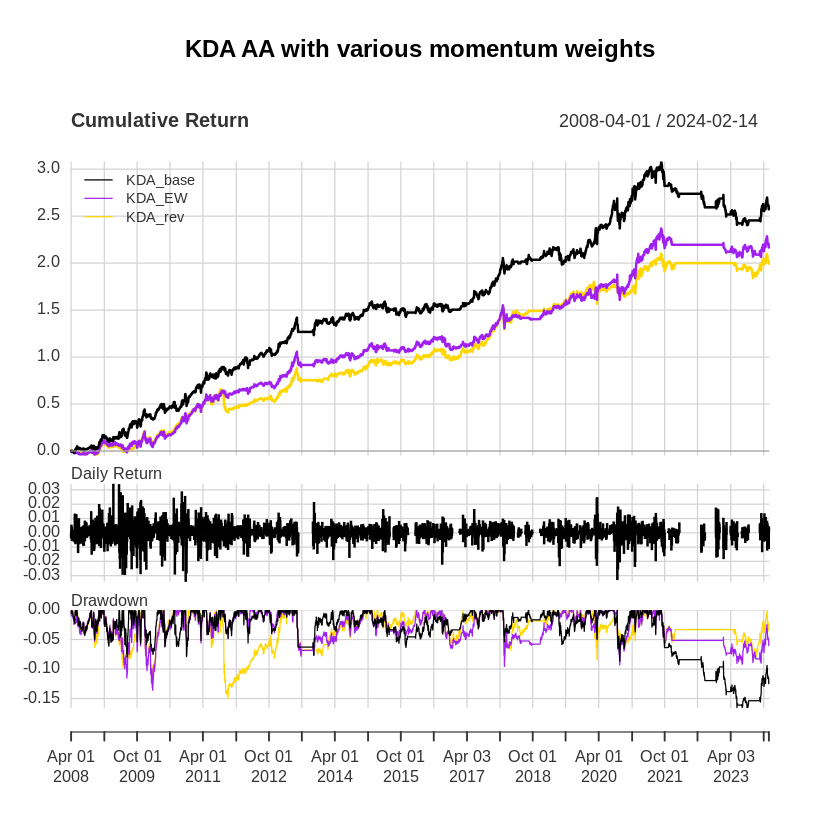

In [ ]:
# different leverages
KDA_100 <- KDA(rets, leverageFactor = 1)
KDA_EW <- KDA(rets, leverageFactor = 1, momWeights = c(1,1,1,1))
KDA_rev <- KDA(rets, leverageFactor = 1, momWeights = c(1, 2, 4, 12))
# KDA_150 <- KDA(rets, leverageFactor = 1.5)
# KDA_200 <- KDA(rets, leverageFactor = 2)

# compare
compare <- na.omit(cbind(KDA_100[[2]], KDA_EW[[2]], KDA_rev[[2]]))
colnames(compare) <- c("KDA_base", "KDA_EW", "KDA_rev")
charts.PerformanceSummary(compare, colorset = c('black', 'purple', 'gold'),
                          main = "KDA AA with various momentum weights")

stratStats(compare)
apply.yearly(compare, Return.cumulative)

,Base,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,⋯,Lag12,Lag13,Lag14,Lag15,Lag16,Lag17,Lag18,Lag19,Lag20,Lag21
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Annualized Return,0.0853000,0.0541000,0.0574000,0.0590000,0.0348000,0.0306000,0.0657000,0.0793000,0.0815000,0.0738000,⋯,0.0590000,0.0563000,0.0978000,0.0997000,0.0883000,0.0932000,0.0882000,0.0806000,0.0975000,0.0953000
Annualized Std Dev,0.0874000,0.0881000,0.0881000,0.0902000,0.0928000,0.0922000,0.0929000,0.0914000,0.0923000,0.0924000,⋯,0.0914000,0.0898000,0.0885000,0.0894000,0.0913000,0.0900000,0.0903000,0.0866000,0.0918000,0.0896000
Annualized Sharpe (Rf=0%),0.9761000,0.6143000,0.6515000,0.6539000,0.3747000,0.3318000,0.7070000,0.8666000,0.8825000,0.7991000,⋯,0.6463000,0.6275000,1.1052000,1.1149000,0.9675000,1.0360000,0.9766000,0.9305000,1.0615000,1.0637000
Worst Drawdown,0.1662145,0.1784779,0.1269223,0.1292180,0.1913601,0.2050490,0.2002413,0.1495586,0.1227779,0.1355470,⋯,0.2013652,0.1937654,0.1498405,0.1224519,0.1290549,0.1274097,0.1006042,0.1032067,0.1161592,0.1517097
Calmar Ratio,0.5131924,0.3031188,0.4522453,0.4565926,0.1818561,0.1492326,0.3281041,0.5302271,0.6638000,0.5444605,⋯,0.2929999,0.2905576,0.6526940,0.8141973,0.6842048,0.7314986,0.8767026,0.7809567,0.8393650,0.6281736
Ulcer Performance Index,1.5894490,0.8493259,1.0947744,1.0277972,0.4525268,0.3774977,0.9105009,1.4841407,1.9642499,1.4887254,⋯,0.9298464,1.0001808,2.7134075,2.8359834,2.6267697,2.6622564,2.6686542,2.0897644,3.0688900,2.6197462


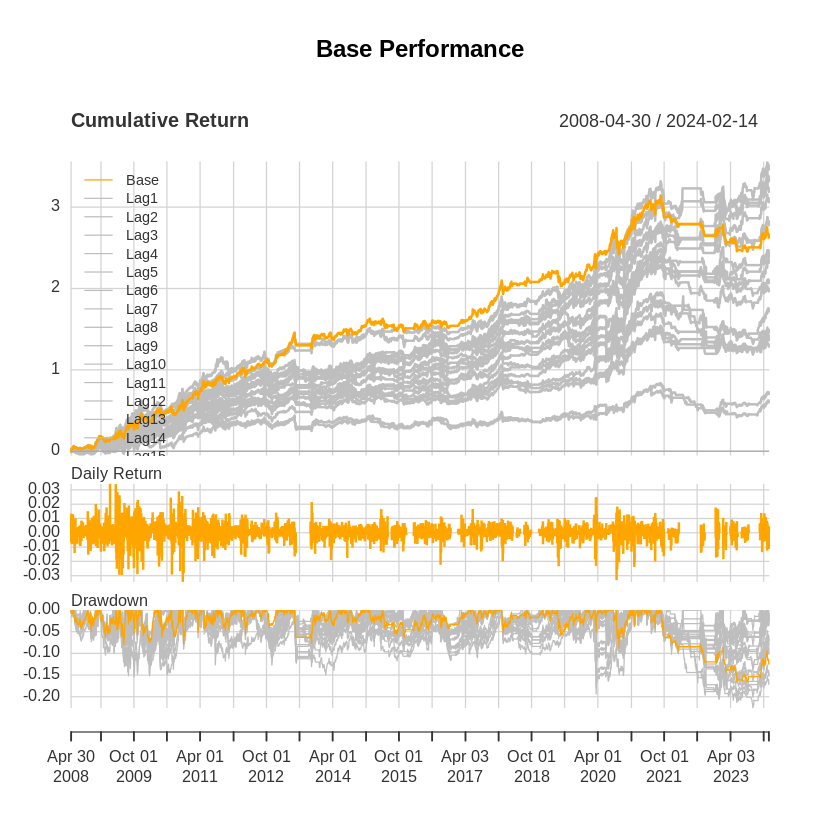

In [ ]:
lagCompare <- list()
for(i in 1:21) {
  offRets <- KDA(rets, leverageFactor = 1, offset = i)
  tmp <- offRets[[2]]
  colnames(tmp) <- paste0("Lag", i)
  lagCompare[[i]] <- tmp
}
lagCompare <- do.call(cbind, lagCompare)
lagCompare <- na.omit(cbind(KDA_100[[2]], lagCompare))
colnames(lagCompare)[1] <- "Base"

charts.PerformanceSummary(lagCompare, colorset=c("orange", rep("gray", 21)))
stratStats(lagCompare)

KDA ASSET ALLOCATION

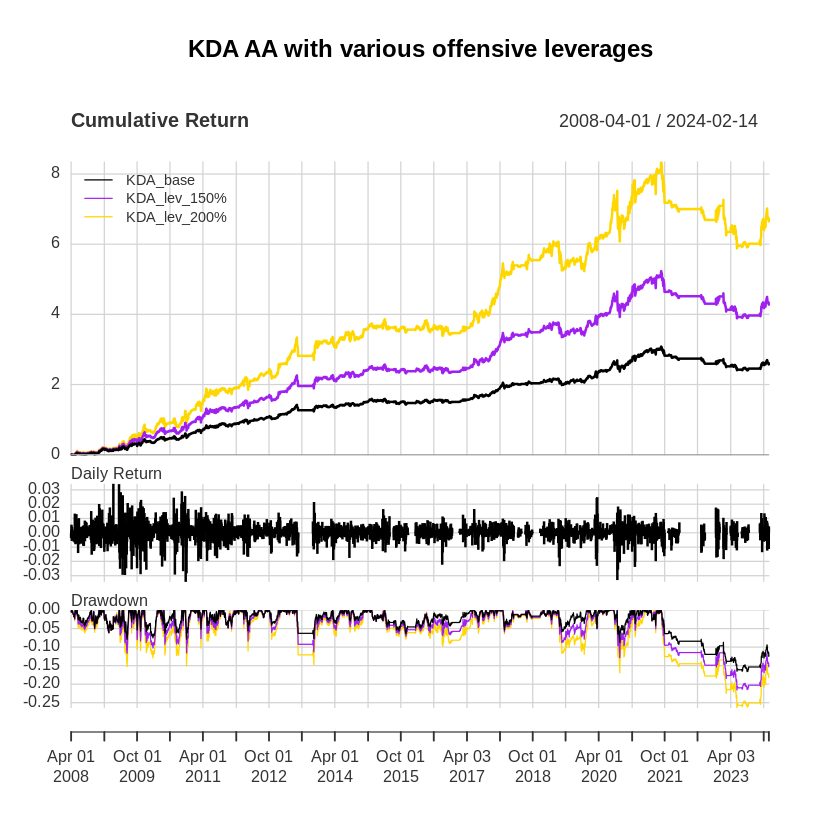

In [ ]:
# KDA asset allocation
# KDA stands for Kernel Defensive Adaptive (Asset Allocation).

# compute strategy statistics
stratStats <- function(rets) {
  stats <- rbind(table.AnnualizedReturns(rets), maxDrawdown(rets))
  stats[5,] <- stats[1,]/stats[4,]
  stats[6,] <- stats[1,]/UlcerIndex(rets)
  rownames(stats)[4] <- "Worst Drawdown"
  rownames(stats)[5] <- "Calmar Ratio"
  rownames(stats)[6] <- "Ulcer Performance Index"
  return(stats)
}

# required libraries
require(quantmod)
require(PerformanceAnalytics)
require(tseries)

# symbols
symbols <- c("SPY", "VGK",   "EWJ",  "EEM",  "VNQ",  "RWX",  "IEF",  "TLT",  "DBC",  "GLD", "VWO", "BND")


# get data
rets <- list()
for(i in 1:length(symbols)) {

    returns <- Return.calculate(Ad(get(getSymbols(symbols[i], from = '1990-01-01'))))
  colnames(returns) <- symbols[i]
  rets[[i]] <- returns
}
rets <- na.omit(do.call(cbind, rets))


# algorithm
KDA <- function(rets, offset = 0, leverageFactor = 1.5) {

  # get monthly endpoints, allow for offsetting ala AllocateSmartly/Newfound Research
  ep <- endpoints(rets) + offset
  ep[ep < 1] <- 1
  ep[ep > nrow(rets)] <- nrow(rets)
  ep <- unique(ep)
  epDiff <- diff(ep)
  if(last(epDiff)==1) { # if the last period only has one observation, remove it
    ep <- ep[-length(ep)]
  }
  # initialize vector holding zeroes for assets
  emptyVec <- data.frame(t(rep(0, 10)))
  colnames(emptyVec) <- symbols[1:10]


  allWts <- list()
  # we will use the 13612F filter
  for(i in 1:(length(ep)-12)) {

    # 12 assets for returns -- 2 of which are our crash protection assets
    retSubset <- rets[c((ep[i]+1):ep[(i+12)]),]
    epSub <- ep[i:(i+12)]
    sixMonths <- rets[(epSub[7]+1):epSub[13],]
    threeMonths <- rets[(epSub[10]+1):epSub[13],]
    oneMonth <- rets[(epSub[12]+1):epSub[13],]

    # computer 13612 fast momentum
    moms <- Return.cumulative(oneMonth) * 12 + Return.cumulative(threeMonths) * 4 +
      Return.cumulative(sixMonths) * 2 + Return.cumulative(retSubset)
    assetMoms <- moms[,1:10] # Adaptive Asset Allocation investable universe
    cpMoms <- moms[,11:12] # VWO and BND from Defensive Asset Allocation

    # find qualifying assets
    highRankAssets <- rank(assetMoms) >= 6 # top 5 assets
    posReturnAssets <- assetMoms > 0 # positive momentum assets
    selectedAssets <- highRankAssets & posReturnAssets # intersection of the above

    # perform mean-variance/quadratic optimization
    investedAssets <- emptyVec
    if(sum(selectedAssets)==0) {
      investedAssets <- emptyVec
    } else if(sum(selectedAssets)==1) {
      investedAssets <- emptyVec + selectedAssets
    } else {
      idx <- which(selectedAssets)
      # use 1-3-6-12 fast correlation average to match with momentum filter
      cors <- (cor(oneMonth[,idx]) * 12 + cor(threeMonths[,idx]) * 4 +
                 cor(sixMonths[,idx]) * 2 + cor(retSubset[,idx]))/19
      vols <- StdDev(oneMonth[,idx]) # use last month of data for volatility computation from AAA
      covs <- t(vols) %*% vols * cors

      # do standard min vol optimization
      minVolRets <- t(matrix(rep(1, sum(selectedAssets))))
      minVolWt <- portfolio.optim(x=minVolRets, covmat = covs)$pw
      names(minVolWt) <- colnames(covs)
      investedAssets <- emptyVec
      investedAssets[,selectedAssets] <- minVolWt
    }

    # crash protection -- between aggressive allocation and crash protection allocation
    pctAggressive <- mean(cpMoms > 0)
    investedAssets <- investedAssets * pctAggressive

    pctCp <- 1-pctAggressive

    # if IEF momentum is positive, invest all crash protection allocation into it
    # otherwise stay in cash for crash allocation
    if(assetMoms["IEF"] > 0) {
      investedAssets["IEF"] <- investedAssets["IEF"] + pctCp
    }

    # leverage portfolio if desired in cases when both risk indicator assets have positive momentum
    if(pctAggressive == 1) {
      investedAssets = investedAssets * leverageFactor
    }

    # append to list of monthly allocations
    wts <- xts(investedAssets, order.by=last(index(retSubset)))
    allWts[[i]] <- wts

  }

  # put all weights together and compute cash allocation
  allWts <- do.call(rbind, allWts)
  allWts$CASH <- 1-rowSums(allWts)

  # add cash returns to universe of investments
  investedRets <- rets[,1:10]
  investedRets$CASH <- 0

  # compute portfolio returns
  out <- Return.portfolio(R = investedRets, weights = allWts)
  return(out)
}

# different leverages
KDA_100 <- KDA(rets, leverageFactor = 1)
KDA_150 <- KDA(rets, leverageFactor = 1.5)
KDA_200 <- KDA(rets, leverageFactor = 2)

# compare
compare <- na.omit(cbind(KDA_100, KDA_150, KDA_200))
colnames(compare) <- c("KDA_base", "KDA_lev_150%", "KDA_lev_200%")
charts.PerformanceSummary(compare, colorset = c('black', 'purple', 'gold'),
                          main = "KDA AA with various offensive leverages")

GARCH AND RUDEMENTARY VOL TRADING

In [ ]:
install.packages("rugarch")

In [ ]:
library(rugarch)
library(xts)

In [ ]:
getSymbols('^VIX', from = '1990-01-01')

# convert GARCH sigma predictions to same scale as the VIX by annualizing, multiplying by 100
garchPreds = xts(garchroll$Sigma * sqrt(252) * 100, order.by=as.Date(rownames(garchroll)))
diff = garchPreds - Ad(VIX)

require(downloader)

download('https://www.dropbox.com/s/y3cg6d3vwtkwtqx/VXZlong.TXT?raw=1', destfile='VXZlong.txt')
download('https://www.dropbox.com/s/jk3ortdyru4sg4n/ZIVlong.TXT?raw=1', destfile='ZIVlong.txt')

ziv = xts(read.zoo('ZIVlong.txt', format='%Y-%m-%d', sep = ',', header=TRUE))
vxz = xts(read.zoo('VXZlong.txt', format = '%Y-%m-%d', sep = ',', header = TRUE))

zivRets = na.omit(Return.calculate(Cl(ziv)))
vxzRets = na.omit(Return.calculate(Cl(vxz)))
vxzRets['2014-08-05'] = .045

zivSig = diff < 0
vxzSig = diff > 0

garchOut = lag(zivSig, 2) * zivRets + lag(vxzSig, 2) * vxzRets

histSpy = runSD(spyRets, n = 21, sample = FALSE) * sqrt(252) * 100
spyDiff = histSpy - Ad(VIX)

zivSig = spyDiff < 0
zivSig = spyDiff > 0

spyOut = lag(zivSig, 2) * zivRets + lag(vxzSig, 2) * vxzRets

avg = (garchOut + spyOut)/2
compare = na.omit(cbind(garchOut, spyOut, avg))
colnames(compare) = c("gjrGARCH", "histVol", "avg")

In [ ]:
require(PerformanceAnalytics)
require(quantmod)
require(stats)
require(xts)

symbols <- c("SPY", "EFA", "EEM", "DBC", "HYG", "GLD", "IEF", "TLT")

# get free data from yahoo
rets <- list()
getSymbols(symbols, src = 'yahoo', from = '1990-12-31')
for(i in 1:length(symbols)) {
  returns <- Return.calculate(Ad(get(symbols[i])))
  colnames(returns) <- symbols[i]
  rets[[i]] <- returns
}
rets <- na.omit(do.call(cbind, rets))

# 12 month PC rolling PC window, 3 month momentum window
pcPlusMinus <- function(rets, pcWindow = 12, momWindow = 3) {
  ep <- endpoints(rets)

  wtsPc1Plus <- NULL
  wtsPc1Minus <- NULL

  for(i in 1:(length(ep)-pcWindow)) {
    # get subset of returns
    returnSubset <- rets[(ep[i]+1):(ep[i+pcWindow])]

    # perform PCA, get first PC (I.E. pc1)
    pcs <- prcomp(returnSubset)
    firstPc <- pcs[[2]][,1]

    # make sure SPY always has a positive loading
    # otherwise, SPY and related assets may have negative loadings sometimes
    # positive loadings other times, and creates chaotic return series

    if(firstPc['SPY'] < 0) {
      firstPc <- firstPc * -1
    }

    # create vector for negative values of pc1
    wtsMinus <- firstPc * -1
    wtsMinus[wtsMinus < 0] <- 0
    wtsMinus <- wtsMinus/(sum(wtsMinus)+1e-16) # in case zero weights
    wtsMinus <- xts(t(wtsMinus), order.by=last(index(returnSubset)))
    wtsPc1Minus[[i]] <- wtsMinus

    # create weight vector for positive values of pc1
    wtsPlus <- firstPc
    wtsPlus[wtsPlus < 0] <- 0
    wtsPlus <- wtsPlus/(sum(wtsPlus)+1e-16)
    wtsPlus <- xts(t(wtsPlus), order.by=last(index(returnSubset)))
    wtsPc1Plus[[i]] <- wtsPlus
  }

  # combine positive and negative PC1 weights
  wtsPc1Minus <- do.call(rbind, wtsPc1Minus)
  wtsPc1Plus <- do.call(rbind, wtsPc1Plus)

  # get return of PC portfolios
  pc1MinusRets <- Return.portfolio(R = rets, weights = wtsPc1Minus)
  pc1PlusRets <- Return.portfolio(R = rets, weights = wtsPc1Plus)

  # combine them
  combine <-na.omit(cbind(pc1PlusRets, pc1MinusRets))
  colnames(combine) <- c("PCplus", "PCminus")

  momEp <- endpoints(combine)
  momWts <- NULL
  for(i in 1:(length(momEp)-momWindow)){
    momSubset <- combine[(momEp[i]+1):(momEp[i+momWindow])]
    momentums <- Return.cumulative(momSubset)
    momWts[[i]] <- xts(momentums==max(momentums), order.by=last(index(momSubset)))
  }
  momWts <- do.call(rbind, momWts)

  out <- Return.portfolio(R = combine, weights = momWts)
  colnames(out) <- paste("PCwin", pcWindow, "MomWin", momWindow, sep="_")
  return(list(out, wtsPc1Minus, wtsPc1Plus, combine))
}


pcWindows <- c(6, 9, 12, 15, 18)
momWindows <- c(1, 3, 6, 10, 12)

permutes <- expand.grid(pcWindows, momWindows)

stratStats <- function(rets) {
  stats <- rbind(table.AnnualizedReturns(rets), maxDrawdown(rets))
  stats[5,] <- stats[1,]/stats[4,]
  stats[6,] <- stats[1,]/UlcerIndex(rets)
  rownames(stats)[4] <- "Worst Drawdown"
  rownames(stats)[5] <- "Calmar Ratio"
  rownames(stats)[6] <- "Ulcer Performance Index"
  return(stats)
}

results <- NULL
for(i in 1:nrow(permutes)) {
  tmp <- pcPlusMinus(rets = rets, pcWindow = permutes$Var1[i], momWindow = permutes$Var2[i])
  results[[i]] <- tmp[[1]]
}
results <- do.call(cbind, results)
stats <- stratStats(results)